# Auditory Brainstem Response. 
3 - 4 min of recording, 1000 repetitions of the sound stimulus are played. This recording is bandpass filtered and broken down into 1000 segments, one per presentation, in a time-locked manner. These segments are averaged to obtain neural response to sound.

(4915200,)


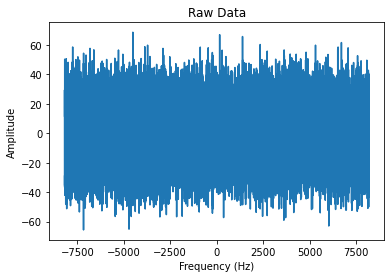

In [1]:
#Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import scipy.io as sio

#Load Data
eegdata = sio.loadmat('eegdata.mat',squeeze_me=True)
#Variables
eeg = eegdata['raw'] # raw recordings
fs = eegdata['fs'] # sampling rate (16384)
clicks = eegdata['clicks'] # sample numbers of raw recording at which sound was initiated
f = np.fft.fftfreq(eeg.shape[0]) * fs
#plot raw data
pl.plot(f,eeg)
pl.xlabel('Frequency (Hz)')
pl.ylabel('Amplitude')
pl.title('Raw Data')
print(eeg.shape)

## Bandpass Filter

In [2]:
#bandpass filter
from scipy import signal
f_high = 40  #High pass frequency (70 - 30)
f_low = 3030 #Low pass frequency (3000 + 30)
N = 546#int(fs/30) # chosen so cutoffs are about 30 Hz sharp
t_h = np.arange(0, N) / fs # time vector with correct length for truncated signal
f = np.fft.fftfreq(N) * fs # frequency axis in Hz
t = np.arange(0, eeg.shape[0])* 1/fs #time axis for full signal
h = signal.firwin(N, [f_high, f_low], pass_zero='bandpass', fs=fs) #create bandpass filter impulse response

Text(0.5, 1.0, 'Bandpass Filter')

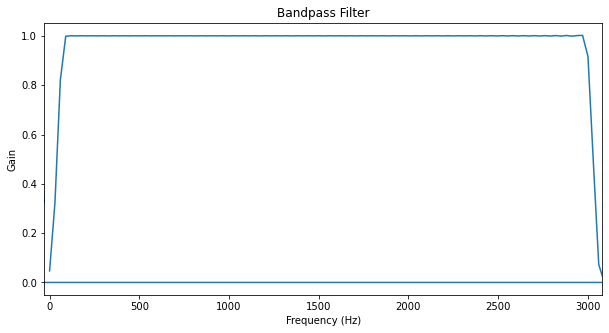

In [3]:
# Calculate and plot magnitude transfer function H(f) of the filter
H = np.fft.fft(h) #impulse in frequency domain
pl.figure(figsize=(10,5))
pl.plot(f, np.abs(H)) # plot H(f)
pl.xlim(-30,3080) # cut out negative bandpass and focus on section showing cutoffs
pl.xlabel('Frequency (Hz)')
pl.ylabel('Gain')
pl.title('Bandpass Filter')

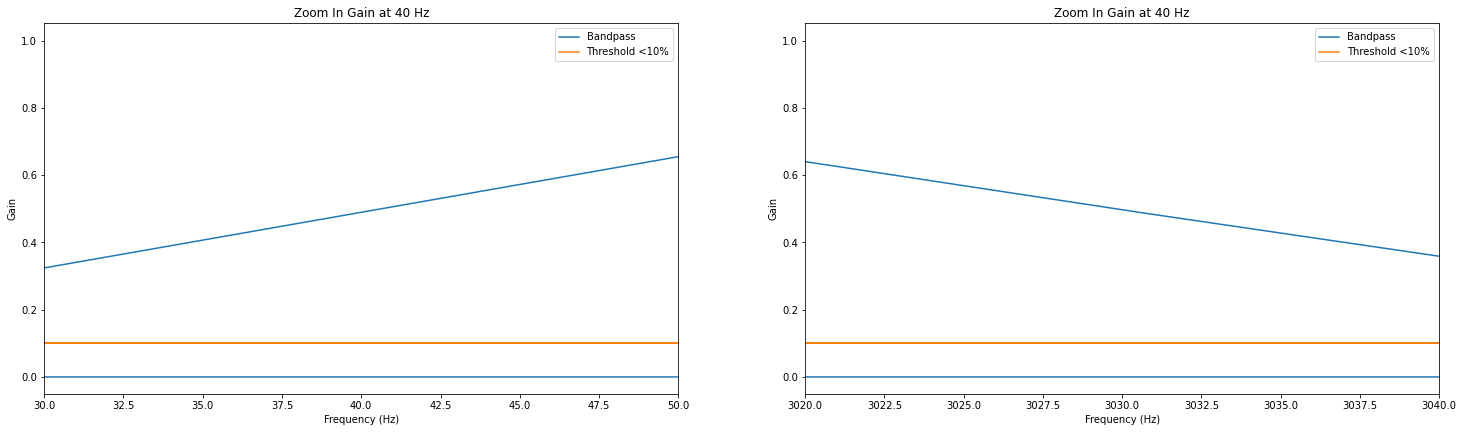

In [4]:
#check gain
threshold = 0.1*np.ones(f.shape[0])
pl.figure(figsize=(25,15))
ax1 = pl.subplot(221)
ax1.plot(f,np.abs(H),f,threshold)
pl.xlim(30,50)
pl.xlabel('Frequency (Hz)')
pl.ylabel('Gain')
pl.title('Zoom In Gain at 40 Hz')
pl.legend(["Bandpass","Threshold <10%"],loc=1)
ax1 = pl.subplot(222)
ax1.plot(f,np.abs(H),f,threshold)
pl.xlim(3020,3040)
pl.xlabel('Frequency (Hz)')
pl.ylabel('Gain')
pl.title('Zoom In Gain at 40 Hz')
pl.legend(["Bandpass","Threshold <10%"],loc=1)
pl.show()

## Apply bandpass filter to the signal
### How should we apply the bandpass?
Since we care about latency measurements, the best way to apply the bandpass is by using the back and forth filtering method. This removes any delays in the filtered signal allowing for analysis of the latency.

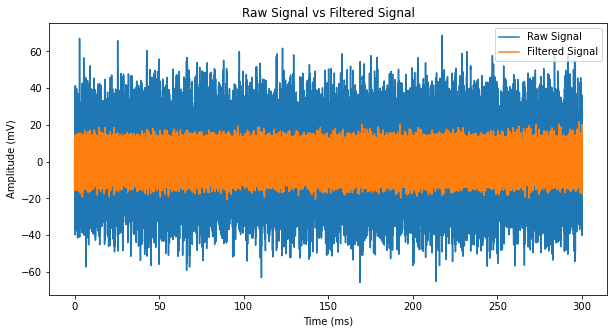

In [5]:
# apply bandpass filter to signal
eeg_filt = signal.filtfilt(h, 1, eeg)
pl.figure(figsize=(10,5))
pl.plot(t, eeg)
pl.plot(t, eeg_filt)
pl.title('Raw Signal vs Filtered Signal')
pl.ylabel('Amplitude (mV)')
pl.xlabel('Time (ms)')
pl.legend(["Raw Signal", "Filtered Signal"],loc=1)
pl.show()

## After filtering, breakdown the data by extracting time samples of interest (12 ms of the data from -2 to +10ms of the onset of each sound)

In [7]:
#make max and min of time range into sample units
tmin = -0.002 * fs
tmax = 0.010 * fs
#create empty epochs matrix
epochs = np.zeros((1000,195))
#loop through all 1000 values of click references in samples 
for n  in  range(len(clicks)):
    array = eeg_filt[(clicks[n] + int(tmin)):(clicks[n] + int(tmax))]
    #array = array.reshape(1,-1)
    epochs[n,:]= array

## Estimate the ABR by averaging the epochs array across the 1000 segments. 
Assuming the noise is uncorrelated from one presentation of the sound to the next in raw data, by what factor would the signal-to-noise ratio (SNR) be improved in the averaged data compared to the raw data?

The signal should lose noise with in the averaged data with a factor of 1000 becausewe will not only be minimizing time in which nothing of interest is happening but also averaging out the random noise. 

In [8]:
#avarage across 1000 segments
ABR = epochs.mean(axis=0)#.reshape(1,-1)

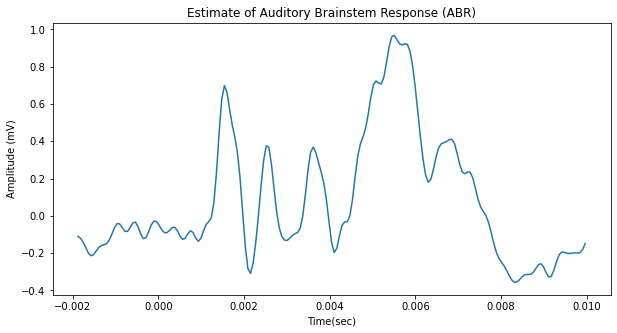

In [9]:
#plot ABR with respect to time onsets
time = np.arange(-0.002,0.010,1/fs)
time = time[2:]
pl.figure(figsize=(10,5))
pl.plot(time, ABR)
pl.xlabel('Time(sec)')
pl.ylabel('Amplitude (mV)')
pl.title('Estimate of Auditory Brainstem Response (ABR)')
pl.show()

## From the plot above identify the time index of the first prominent positive peak. This is the latency, which is used to diagnose hearing loss or anomaly. Latency of more than 2.5ms would be a red flag. 

The data does not raise any red flags. The first prominent positive peak is before 2 ms. In other words, latency is less than 2 ms.

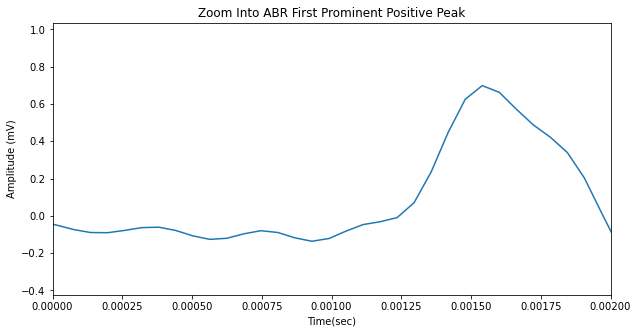

In [10]:
#Zoom into first prominent peak
pl.figure(figsize=(10,5))
pl.plot(time, ABR)
pl.xlim(0.000,0.002)
pl.xlabel('Time(sec)')
pl.ylabel('Amplitude (mV)')
pl.title('Zoom Into ABR First Prominent Positive Peak')
pl.show()